In [1]:
import os
import math

from pathlib import Path
from preprocess import *

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, models

Download the speech commands dataset if not already downloaded.

In [2]:
data_dir = download_speech_dataset(pathlib.Path("data/"))

In [3]:
command_dirs = tuple(filter(Path.is_dir, pathlib.Path(data_dir).iterdir()))
commands = [p.name for p in command_dirs]
commands.sort()

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
np.random.shuffle(filenames)
print(f"Number of samples: {len(filenames)}\n"
      f"Samples per label: {sum(map(lambda _: 1, command_dirs[0].iterdir()))}")

Number of samples: 8000
Samples per label: 1000


Split data into:

- train
- validation
- test

sets.

In [5]:
splits = split_train_test_validate(filenames)

print("Train, val, test sizes = ", 
      ",".join(map(str,map(len, [splits[0], splits[2], splits[1]]))))

Train, val, test sizes =  6400,800,800


Preprocess data in order to generate STFT spectrograms from the audio samples,
and do batching of input data.

In [6]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

train_ds, val_ds, test_ds = tuple(
    map(lambda files: preprocess_dataset(files, commands), splits))

input_shape = next(iter(map(lambda t: t[0].shape, train_ds.take(1))))

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Define the current model for audio recognition.

Basic CNN model that runs on spectrogram images.

In [7]:
num_labels = len(commands)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Compile the model and target for accuracy.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model.

In [9]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
400/400 [==============================] - 8s 10ms/step - loss: 1.8184 - accuracy: 0.3394 - val_loss: 1.0440 - val_accuracy: 0.6787
Epoch 2/20
400/400 [==============================] - 3s 7ms/step - loss: 0.9711 - accuracy: 0.6520 - val_loss: 0.7255 - val_accuracy: 0.7738
Epoch 3/20
400/400 [==============================] - 3s 7ms/step - loss: 0.7370 - accuracy: 0.7338 - val_loss: 0.5912 - val_accuracy: 0.7950
Epoch 4/20
400/400 [==============================] - 3s 7ms/step - loss: 0.5621 - accuracy: 0.8062 - val_loss: 0.5387 - val_accuracy: 0.8138
Epoch 5/20
400/400 [==============================] - 3s 7ms/step - loss: 0.4740 - accuracy: 0.8315 - val_loss: 0.5099 - val_accuracy: 0.8238
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 0.4248 - accuracy: 0.8508 - val_loss: 0.4772 - val_accuracy: 0.8300
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 0.3797 - accuracy: 0.8631 - val_loss: 0.4723 - val_accuracy: 0.8388
Epoch

Visualize accuracy against epoch number.

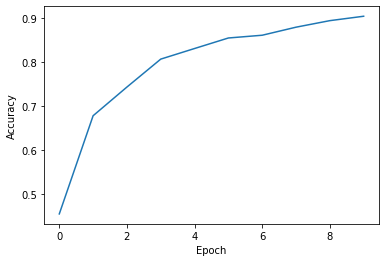

In [10]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Run predictions on the test data.

In [11]:
test_audio = np.zeros([len(splits[1])] + input_shape.as_list(), 
                      dtype=np.float32)
test_labels = np.zeros([len(splits[1])], dtype=np.int)

for i, (audio, label) in enumerate(test_ds.as_numpy_iterator()):
    test_audio[i] = audio
    test_labels[i] = label

Obtain accuracy of the model on the test data.

In [12]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = np.sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 85%


Plot the confusion matrix.

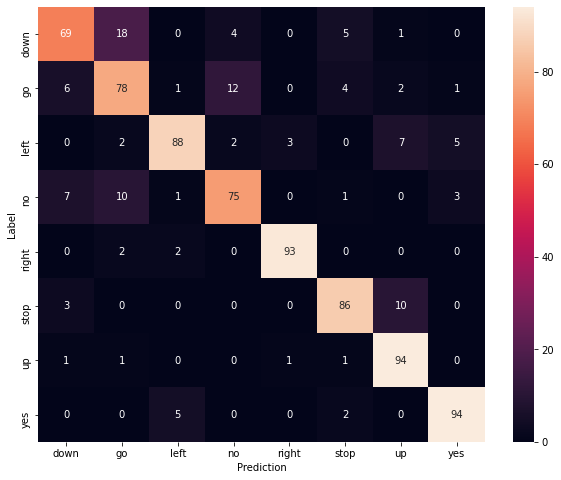

In [14]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Save the model so that it can be used for inference on the cloud.

In [21]:
model_path = pathlib.Path("saved/audiorecog")
if not (model_path_parent := model_path.parent).exists():
    model_path_parent.mkdir(parents=True)
model.save(model_path)

INFO:tensorflow:Assets written to: saved/audiorecog/assets
